# Random Walk with Regime Changes Dataset

This script generates a synthetic dataset consisting of random walk time series, with a subset exhibiting distinct regime changes. These time series emulate multiple scenarios that might be encountered in financial markets, economics, and other fields where regime changes (shifts in underlying data generating processes) are common.

To ensure reproducibility, seeds are set for both numpy and the Python random library.

The foundation of each series is a simple random walk. Each time point in the series is the sum of the previous point and a random step, drawn from a standard normal distribution.

Distinct regime changes are introduced in a subset of these series. The possible regime changes are:

1. **Change in Drift:** A constant drift, which can be either +0.3 or -0.3, is introduced at a random point in the series. This simulates scenarios where there's a consistent increase or decrease in values over time, such as a sustained bull or bear market in financial contexts.
2. **Change in Epsilon (Variance):** The variance of the random steps changes at a certain point, transitioning from a standard deviation of 1 to 3. This can represent periods of heightened volatility in the series.
3. **Change in Both Drift and Epsilon:** A combination of both drift and variance changes is introduced. This makes the series exhibit simultaneous changes in trend and volatility, representing the most complex scenario where both the trend and volatility of a series shift.

The dataset is structured as:

- **series_id:** A unique identifier for each time series, formatted as "series_X" where X is an integer.
- **time_step:** Represents the time point in the series, ranging from the start to the specified end.
- **value:** The value of the random walk process at each time step.

The **Random Walk with Regime Changes Dataset** is versatile and can be used for:

- **Time Series Forecasting:** The dataset, with its inherent temporal dependencies, is apt for training and evaluating forecasting models.
- **Regime Change Detection:** With intentional regime changes in a subset of the series, this dataset is a valuable resource for testing algorithms that detect shifts in time series behavior.

The dataset's blend of simplicity (from the basic random walk) and complexity (from the regime changes) makes it an excellent tool for understanding, developing, and testing various time series analysis techniques.


In [203]:
import numpy as np
import pandas as pd
from typing import List
import random
import string
import matplotlib.pyplot as plt
import os
from typing import Tuple, Union
%matplotlib inline

In [196]:
dataset_name = "random_walk"

In [197]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Functions to generate data

In [198]:
def generate_series(num_series, num_time_steps, num_regime_change_series, regime_change_per_type):
    # Helper function to generate a unique series_id
    def generate_id(size=8, chars=string.ascii_uppercase + string.digits):
        return ''.join(random.choice(chars) for _ in range(size))
    
    all_series = []  # List to store dataframes for each series
    
    # Define regime change parameters
    drift_change = np.random.choice([-0.3, +0.3])
    std_dev_original = 1
    std_dev_changed = 3
    
    # List of series that will have regime changes
    regime_series = random.sample(range(num_series), num_regime_change_series )
    print("regime change series: ", sorted(regime_series))
    
    # Distribute the regime change types
    regime_types = ["drift", "epsilon", "both"] * regime_change_per_type
    
    for i in range(num_series):
        # Generate random walk
        epsilon = np.random.normal(scale=std_dev_original, size=num_time_steps - 1)
        random_walk = np.concatenate(([0], np.cumsum(epsilon)))
        
        # If the series has a regime change
        if i in regime_series:
            regime_type = regime_types.pop()
            change_point = random.randint(1, num_time_steps-1)  # Random point for regime change
            
            if regime_type == "drift":
                random_walk[change_point:] += drift_change * np.arange(1, num_time_steps - change_point + 1)
                
            elif regime_type == "epsilon":
                epsilon_new = np.random.normal(scale=std_dev_changed, size=num_time_steps - change_point)
                random_walk[change_point] = random_walk[change_point-1] + epsilon_new[0]
                random_walk[change_point+1:] = random_walk[change_point] + np.cumsum(epsilon_new[1:])
               
                
            elif regime_type == "both":
                epsilon_new = np.random.normal(scale=std_dev_changed, size=num_time_steps - change_point)
                drift_trend = drift_change * np.arange(num_time_steps - change_point)
                random_walk[change_point:] = random_walk[change_point-1] + drift_trend + np.cumsum(epsilon_new)
        
        series_id = f"series_{i}"
        series_data = pd.DataFrame({
            "series_id": [series_id for _ in range(num_time_steps)],
            "time_step": range(num_time_steps),
            "value": random_walk
        })
        
        all_series.append(series_data)
        
    # Concatenate all series into a single dataframe
    df = pd.concat(all_series, ignore_index=True)
        
    return df

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
    
# Generate the data using the provided specifications
data = generate_series(
    num_series=70,
    num_time_steps=500,
    num_regime_change_series=21,
    regime_change_per_type=7)
data.head()

regime change series:  [1, 2, 3, 5, 13, 14, 17, 27, 28, 31, 32, 34, 35, 37, 38, 43, 47, 57, 58, 63, 69]


,series_id,time_step,value
0,series_0,0,0.000000
1,series_0,1,-0.550234
2,series_0,2,-0.034801
3,series_0,3,0.439059
4,series_0,4,1.807510


In [199]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
    
# Generate the data using the provided specifications
data = generate_series(
    num_series=70,
    num_time_steps=500,
    num_regime_change_series=21,
    regime_change_per_type=7)
data.head()

regime change series:  [1, 2, 3, 5, 13, 14, 17, 27, 28, 31, 32, 34, 35, 37, 38, 43, 47, 57, 58, 63, 69]


,series_id,time_step,value
0,series_0,0,0.000000
1,series_0,1,-0.550234
2,series_0,2,-0.034801
3,series_0,3,0.439059
4,series_0,4,1.807510


# Visualize Data

In [200]:
def visualize_series(df: pd.DataFrame, filename: str=None, max_series: int=10) -> None:
    """
    Visualizes the series in the provided DataFrame using subplots and saves the plot as a PNG file.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the series data with columns series_id, t, and y.
    - filename (str): Name of the file to save the plot.
    
    Returns:
    - None
    """
    t = df['time_step'].unique()
    unique_series = sorted(df['series_id'].unique())
    
    fig, axes = plt.subplots(nrows=len(unique_series[:max_series]), ncols=1, figsize=(6, 8), sharex=True)

    for i, _ in enumerate(unique_series[:max_series]):
        series_id = f"series_{i}"
        y = df[df['series_id'] == series_id]['value'].values
        axes[i].plot(t, y, label=series_id, color="blue")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel("Time")
    fig.suptitle("Random Walk Dataset", y=0.98)
    plt.tight_layout()
    
    # Save the figure
    if filename is not None:
        plt.savefig(filename)
    # Display the plot in Jupyter Notebook
    #plt.show()

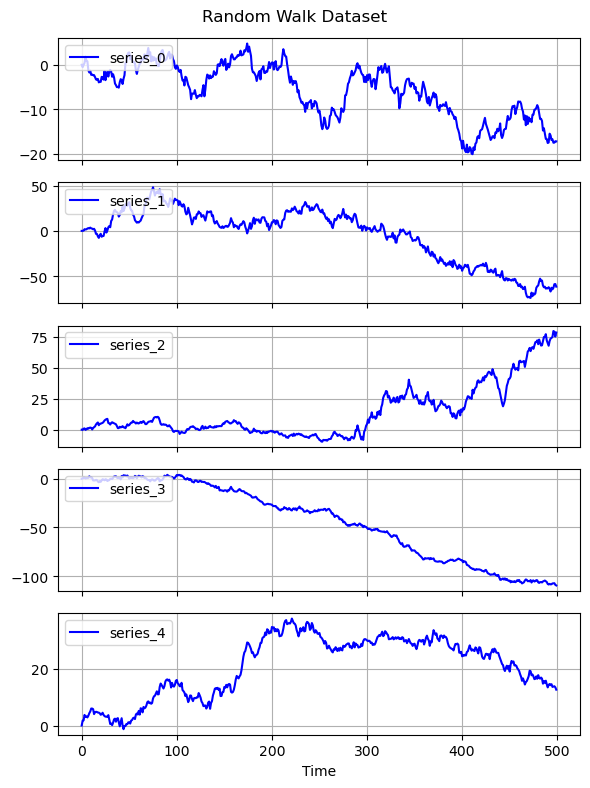

In [204]:
# Visualize
visualize_series(data, outp_fig_fname, max_series=5)

# Save Main Data File

In [202]:
data.to_csv(outp_fname, index=False, float_format="%.3f")